In this Notebook we will implement a basic version of Gaussian Processes.

For this, recall a Gaussian Process is a Stochastic process, where each (finite) subset of Datapoints $D = \{x_i\}_i$ is distributed to some Normal (Gaussian ) distribution: $D \sim N(\mu_u, \Sigma_i)$, where $\mu$ and $\Sigma$ are the mean and (co-)variance respectively.

Implementing a Gaussian Process is more a mathematical than an Computational Problem, making it efficient is however not that straightforward. In the following we make no claim of computational optimality, so if you intend to use Gaussian Processes in your application, be advised to use one of the many fantastic, already existing Packages.

In this project we will be using JAX.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import config
config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
from functools import partial

We will approximate the following function:

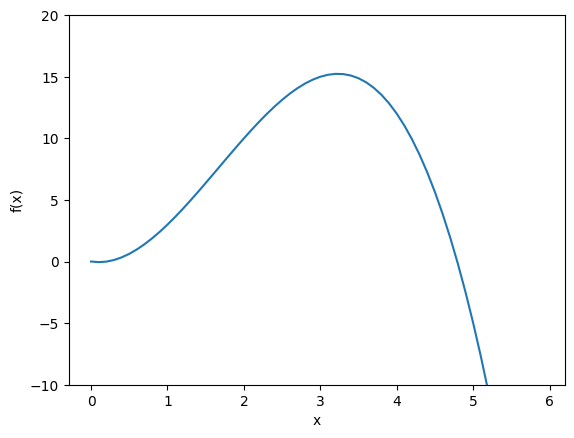

In [2]:
def f(x):
    return -x**3 + 5*x**2 -x 

import matplotlib.pyplot as plt
xx = jnp.arange(0., 6, 0.1)
yy = [f(x) for x in xx]
fig = plt.figure()
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10,20);
plt.show()

The biggest task in using Gaussian Processes is using an appropriate Kernel Function.
In the following, we implement some for later use:

    - RBF kernel (Eucilidic distance)
    - ARD kernel (Mahalanobis distance)
    -

In [3]:
#@jax.jit
def rbf_kernel(x, y, l=0.1):
    return jnp.exp(-jnp.divide(jnp.vdot(x-y,x-y), 2*jnp.power(l,2)))

#@jax.jit
def ARD_kernel(x,y, sigma_inv ,l=0.1):
    return jnp.exp(
        -jnp.divide(
        jnp.vdot((x-y), sigma_inv @ (x-y)) ,  2*jnp.power(l,2)
        )
    )

For Inference, we will need to calculate the conditionial expectation $\mu$ and the conditional variance $\Sigma$:

In [4]:
def Gram_XX(D, kernel):
    #Calculates the Gram matrix of the Data
    #return jnp.array([kernel(x,y) for x in D for y in D]).reshape(len(D),len(D))
    f1 = jax.vmap(kernel, (None, 0))
    return jax.vmap(f1, (0, None))(D,D)


@partial(jax.jit, static_argnames=['kernel'])
def K_TXstar(x,D, kernel):
    s = jax.vmap(kernel,(None, 0))
    return s(x, D)

@partial(jax.jit, static_argnames=['kernel'])
def Sigma_starstar_L(x, kernel, ktxstar, L):        
    v = jnp.linalg.solve(L, ktxstar)
    return (kernel(x,x) - jnp.vdot(v,v))

#Calculates the variance of the posterior p(x|D)
@partial(jax.jit, static_argnames=['kernel'])
def post_variance(x, D, kernel, L):
    ktx = K_TXstar(x, D, kernel)
    v = jnp.linalg.solve(L, ktx)
    variances =  (kernel(x,x) - jnp.vdot(v,v))
    variances = jnp.abs(variances)
    return variances

@partial(jax.jit, static_argnames=['kernel'])
def posterior_mean(x, prior_mean_x, D, fd, prior_mean_D, kernel, L):
    ktx = K_TXstar(x, D, kernel)
    y = fd - prior_mean_D
    v = jnp.linalg.solve(L, y)
    alpha = jnp.linalg.solve(L.T, v)
    return prior_mean_x + ktx @ alpha


#Following: Used for the Optimization:
#wrapper around post_variance that calculates the sum of the variances
@partial(jax.jit, static_argnames=['kernel'])
def __std_loss(xx, D, kernel, Lxx):
    variances =  jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, Lxx)
    losses = jnp.sqrt(variances)
    stepsize = xx[1]-xx[0]
    return jnp.sum(losses)*stepsize

#wrapper around __variance_loss, includes the calculation of the Cholesky decomposition of the Gram matrix of D
@partial(jax.jit, static_argnames=['kernel'])
def std_loss_calculator(xx, D, kernel):
    Lxx = jnp.linalg.cholesky(Gram_XX(D, kernel))
    return __std_loss(xx, D, kernel, Lxx)

In [5]:
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])

kernel = lambda x, y : rbf_kernel(x, y, l= 0.1)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))

posterior_mean(jnp.array(1.5), jnp.array(0), D, fd, jnp.zeros(fd.shape), kernel, L)

Array(4.84464912e-05, dtype=float64)

Let us know check that we can Indeed obtain the posterior Mean and standard diviations, e.g. we can find an approximate $\hat{f}(x)$ represented by the $GP$.

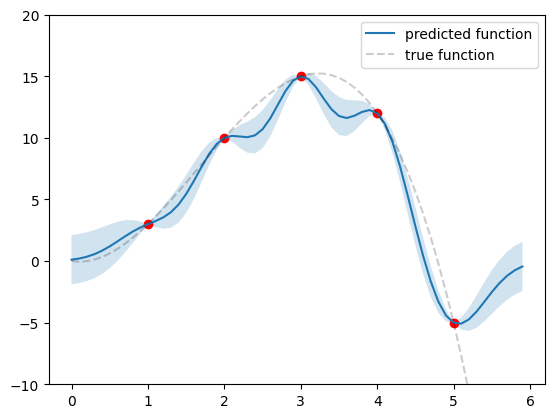

In [6]:
#D: x values we condition on
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])

kernel = lambda x, y : rbf_kernel(x, y, l= 0.4)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)
plt.plot(xx, ys, label='predicted function')
plt.plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
plt.fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
plt.scatter(D, fd, color='red')
plt.ylim(-10,20)
plt.legend()

# Active Learning

In active learning the goal is to approximate a function $f(x)$ to the best of our possibilities, while keeping the needed function evaluations to a minimum; one (propably not optimal, but acceccisble) approach is to queuery for the points with lowest confidence = largest variance.


Consinder the problem of finding the optimal support positions for a gaussian Process:
Without any Datapoints to condition on, it follows the posterior, in our case $x\sim \mathcal{0,1}$

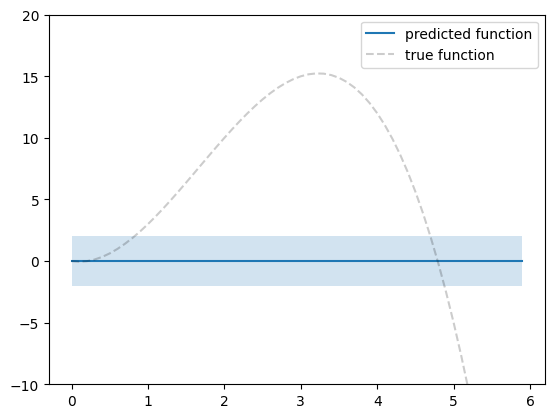

In [7]:
figure = plt.figure()
plt.plot(xx, jnp.zeros_like(xx), label='predicted function')
stds = jnp.ones(xx.shape)
plt.plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
plt.fill_between(
        xx, 
        0. - 2*stds,  # 95% confidence interval
        0. + 2*stds,
        alpha=0.2    # transparency
    )
plt.ylim(-10,20)
plt.legend()


What are the Best points to achieve a good representation of $f(x)$?

With the example from above, we can:

    1.) select a point of maximum merit
    2.) compute f(x)
    3.) condition the GP on (x, f(x))
    4.) repeat until profit

In [31]:
#SETTINGS FOR THE PROBLEM
lower_domain_limit = 0
upper_domain_limit = 6
xx = jnp.arange(lower_domain_limit, upper_domain_limit, 0.1)
xx_fine = jnp.arange(lower_domain_limit, upper_domain_limit, 0.01)  

1.) choose a random point. Due to implementation limitations, we do not actually draw from the gaussian process; however since it is not conditioned on anything, we can just draw according to our prior (which we assume as $\mathcal{N}(0,1)$, and hence $x_1 \sim$ Uni $(D)$ with D the domain of intrest).


In [9]:
key = jax.random.PRNGKey(0)
x_0 = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)

2.) In this example, we can just call the python function $f(x)$; however in general this may be arbitrary complex, e.g. running a COMSOL simulation, train a ML model or whatever we want.

In [10]:
y_0 = f(x_0)

3.) Now we need to condition on (x, f(x)), that is calculate $m_{\star | X}$ and $\Sigma_{\star | X}$. We will calculate most of it during the prediction call; however it is smart to precalculate the expensive (and constant parts) of the expression $L$:
(L is the Cholesky decomposition of our Gram Matrix, and as such scales with $N^3$, hence we want to cache the calculation before using it in the prediction step, which then goes with $N^2$)

In [11]:
D = jnp.array(x_0)
fd = jnp.array(y_0)
kernel = lambda x,y : rbf_kernel(x,y, l=0.4)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))

We then can make a prediction:

In [12]:
mus = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

Text(0, 0.5, 'Standart Deviation')

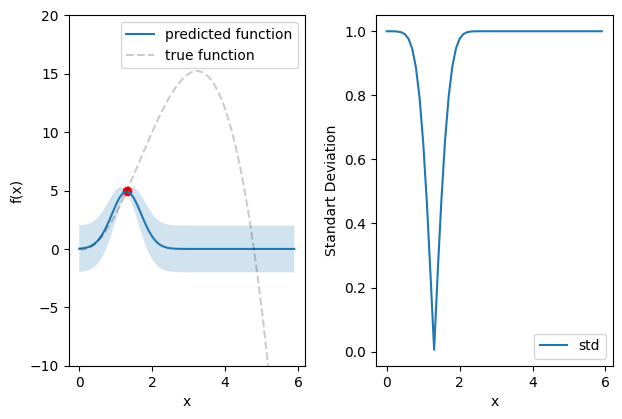

In [13]:
fig, axes  = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, wspace=0.3)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[1].plot(xx, stds, label='std')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Standart Deviation')


4.) / 1.)
Now we need to select the newest point: For this, find the point with the most merit:
We can do this on the whole domain, as now the evaluation of the GP is (comperatively) cheap!
(In this example, the most merit is just the most reduction of variance, )

For this we use the expected integrated standard deviation as a Loss:
$$\mathcal L = \int \sigma_{x,x} p(\sigma_xx |\tilde{D}) dx,$$
where $\tilde{D}$ is the new Conditioning of the Gaussian Process. 
The Merit function is then just the inverse, $M = 1/\mathcal{L}$, hence maximizing the Merit is equivalent to minimizing the Loss $\mathcal{L}$.

We want the newest point to be the one which minimizes it, while being within our Domain.

In this one dimensional example, we can explicitly search for the optimal choice.
However, in high dimensional problems this already is no longer feasible.
Luckily, our Loss is piecewise Convex (it is convex on the Simplex spanned by the $dim+1$ conditioning points, I believe).
Hence, finding the optimal value in each Simplex is "easy", and we "just" need to repeat that for each Simplex.
Since out Loss is differentiable (yey, this is why we use JAX), we can use Optimizations like Gradient Descent.

In [14]:
# (Gradient descent with Hessian acceleration)
def gradient_descend(x_0, D, domain_limits, epsilon = 1e-5, maxiter = 1000, eta = 0.01):
    x = x_0
    lower_domain_limit, upper_domain_limit = domain_limits
    #run for as long as we can
    for iter in range(maxiter):
        D_internal = jnp.append(D, x)
        grad = jax.grad(std_loss_calculator, argnums=1)(xx, D_internal, kernel)
        #print(f"D: {D_internal}")
        loss = std_loss_calculator(xx, D_internal, kernel)
        grad = grad.flatten()[-1]
        if jnp.isnan(grad).any():
            print(f"grad is NAN at {x}")
            break
        #early stopping conditions
        if abs(grad) < epsilon:
            hess = jax.hessian(std_loss_calculator, argnums=1)(xx, D_internal, kernel)
            if hess > 0:
                print(f"grad {grad} smaller epsilon {epsilon}, early stopping at {x}")
            break
        
        delta_x = eta * grad
        #print(f"Loss: {loss} deltax: {delta_x}, grad: {grad}, hess: {hess}")
        #outside of domain: bring back into domain
        if x - delta_x < lower_domain_limit:
            x = (x - lower_domain_limit) /2 + lower_domain_limit
            break

        elif x - delta_x > upper_domain_limit:
            x = (upper_domain_limit - x )/2 + x
            break   
        else:
            x = x - delta_x
        
    return x

In [15]:
gradient_descend( jnp.array(1.105), D, (lower_domain_limit, upper_domain_limit), maxiter=100, eta = 0.05)

Array(0.59881663, dtype=float64)

Great, it found something! Let us now do the Gradient Descent on each Simplex, that is in $1-D$ each interval $[l, x_1], [x_1, x_2] \dots [x_n, r]$, where $l$ and $r$ are the domain boundaries.

As a staring point, let us choose the middle of each Simplex.

In [40]:
def x_midpoints(D):
    x_initials = []
    for i in range(len(D)+1):
        x_i = 0
        if i == 0:
            x_i = (D[0] - lower_domain_limit)/2 + lower_domain_limit
        elif i == len(D):
            x_i = (upper_domain_limit - D[-1])/2 + D[-1]
        else:
            x_i = (D[i] - D[i-1])/2 + D[i-1]
        x_initials.append(x_i)
    return jnp.array(x_initials)

In [41]:

x_initials = x_midpoints(D )

In [42]:
x_initials

Array([0.64888636, 2.46724563, 4.81835927], dtype=float64)

In [19]:
proposed_xs = jnp.array([gradient_descend(x_i, D, (lower_domain_limit, upper_domain_limit), maxiter=100, eta=5e-3) for x_i in x_initials])

Now let us choose the point of the highest merit of these proposed points:

In [33]:
losses = jnp.array([std_loss_calculator(xx_fine, jnp.append(D, jnp.array(x)), kernel) for x in proposed_xs])
best_x = proposed_xs[jnp.argmin(losses)]

The proposed point $x_{\text{proposed}}$ is now a point of maximum Merit! (in the sense that we found it with gradient descent and merit means less total variance if we condition on it...)
In this simple example, it is feasible to just iterate through a fine grid, e.g. xx (which we use to evaluate the loss anyways...)

Text(0.5, 0, 'x')

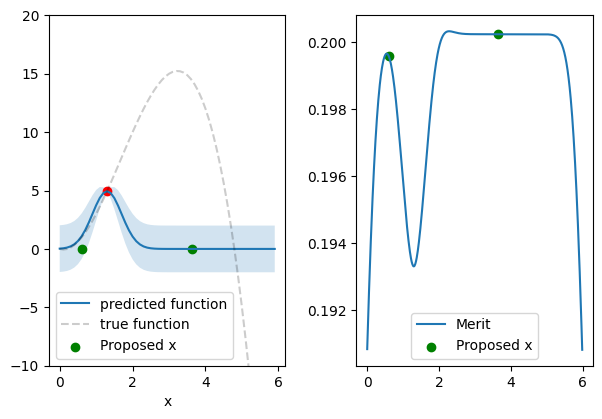

In [34]:
iter_loss = lambda x: partial(std_loss_calculator, xx=xx_fine, kernel=kernel)(D = jnp.append(D, jnp.array(x)))
domain_losses = jax.vmap(iter_loss)(xx_fine)
fig, axes  = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, wspace=0.3)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].scatter(jnp.array(proposed_xs), jnp.zeros_like(jnp.array(proposed_xs)), color='green', label='Proposed x')
axes[0].set_ylim(-10,20)
axes[1].plot(xx_fine, 1/domain_losses, label='Merit')

axes[1].scatter(jnp.array(proposed_xs), (1/ jnp.array(losses)), color='green', label='Proposed x')

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('x')



But how good is our guess?

We are lucky and indeed found the best possible next position (in terms of merit). However, in non convex optimization problems this is not guarenteed! (otherwise I would be jobless, so thats a good thing.)

For now, let us add the condition on $x_{\text{proposed}}$ and call it a day.

In [36]:
D = jnp.append(D, best_x)
#calculate the new f(x_proposed) aswell!
fd = jnp.append(fd, f(best_x))
#obtain new predictor
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
mus = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
stds = jnp.sqrt(jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L))


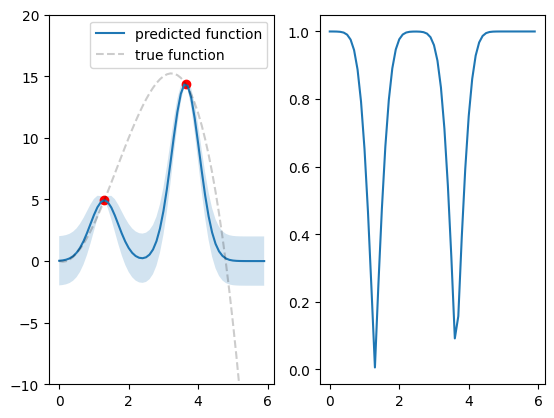

In [38]:
fig, axes  = plt.subplots(1,2)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].legend()
axes[1].plot(xx, stds, label='Variance')

Now that we have an Idea of how this works, lets add it all together into a single algorithm:

In [43]:
def active_learner(f, N, domain_limits, kernel, key = jax.random.PRNGKey(0)):
    #N: number of supporting points
    #f: function we wish to approximate
    #domain_limits: tuple of lower and upper domain limits
    #kernel: kernel function
    lower_domain_limit, upper_domain_limit = domain_limits
    xx = jnp.arange(lower_domain_limit, upper_domain_limit, 0.1)
    xx_fine = jnp.arange(lower_domain_limit, upper_domain_limit, 0.01)

    x_0 = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)
    y_0 = f(x_0)
    D = jnp.array(x_0)
    fd = jnp.array(y_0)

    for i in range(N):
        x_initials = x_midpoints(D)
        proposed_xs = jnp.array([gradient_descend(x_i, D, domain_limits, maxiter=100, eta=5e-3) for x_i in x_initials])
        losses = jnp.array([std_loss_calculator(xx_fine, jnp.append(D, jnp.array(x)), kernel) for x in proposed_xs])
        best_x = proposed_xs[jnp.argmin(losses)]
        D = jnp.append(D, best_x)
        fd = jnp.append(fd, f(best_x))
    
    return D, fd

In [45]:
D_learned, fd_learned = active_learner(f, 5, (0,6), kernel, key = jax.random.PRNGKey(0))

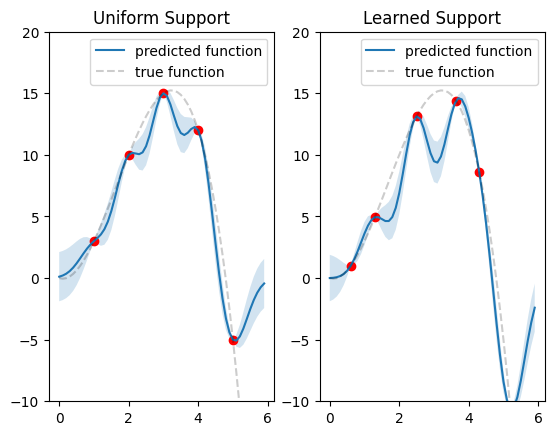

In [50]:
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])

fig, axes  = plt.subplots(1,2)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].set_title("Uniform Support")
axes[0].legend()


L = jnp.linalg.cholesky(Gram_XX(D_learned, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D_learned, fd_learned, jnp.zeros(fd_learned.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D_learned, kernel, L)
stds = jnp.sqrt(vars)

axes[1].plot(xx, ys, label='predicted function')
axes[1].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[1].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[1].scatter(D_learned, fd_learned, color='red')
axes[1].set_ylim(-10,20)
axes[1].set_title("Learned Support")
axes[1].legend()

We see that in both cases our function is drawn too much towards the 0, the prior mean. Reason for this is a too short lengthscale.
Ofcourse we could now manually change the lengthscale a better value.
Or, we do the ML approach and fit it. For this, we do leave one out cross validation, and take as a loss the sum of the negative log likelihood:
$$\mathcal{L} = -\sum_i log(p_\text{GP}(x_i|D/\{x_i\}, l)) $$
We can than mimimize this w.r.t. $l$.

In [51]:
#TODO: Implement the kernel learning